<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/Autoencoder_new_Mnist_%E6%80%A7%E8%83%BD%E6%B5%8B%E8%AF%95_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

搭建神经网络.

2020年1月2号考虑改变输入输出图片的大小，使得训练模型满足实际图片的需求。

2020年1月3日 决定先采用resize实验数据的方式，尽快获得训练结果。

2020年1月9日 先将multimode fiber裁剪到56**56，再resize为28*28，作用是去除空白区域，希望能够提高识别准确度。

2020年3月3日  用新采集的24 hour mix datasets来进行训练。测试transfer learning
\MMF的稳定性，并且尝试寻找新的定义fidelity的方法（如论文中提到的SSIM等）

2020年3月8日 从24hours数据中选择mnist，测试average SSIM以及variance。
Running time 以及 reconstruction time。



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/Colab Notebooks/MMF data/

/content/drive/My Drive/Colab Notebooks/MMF data


In [3]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from skimage.metrics import structural_similarity as ssim

搭建神经网络 autoencoder

In [4]:
#lrelu函数
def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

#输入到网络的数据
#图片28*28,color_channel是1
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1])
#原始数据
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1])

filter_Number = 256
### Encoder
'''
filters: 32个卷积核
kernel_size: 卷积核大小
strides: 长宽步长都是1
padding: 边缘填充
use_bias: 在卷积中添加偏置
activation: 激活函数
'''
with tf.name_scope('en-convolutions'):
    conv1 = tf.layers.conv2d(inputs_, filters=filter_Number,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=tf.nn.relu, )
# 卷积时padding是SAME,所以仍然是28*28
# now 28x28x32
'''
将第一卷积层的结果输入进来
pool_size: 池化窗口
strides: 步长
'''
with tf.name_scope('en-pooling'):
    maxpool1 = tf.layers.max_pooling2d(conv1,
                                       pool_size=(2, 2),
                                       strides=(2, 2), )

# 池化之后变成了14*14
# now 14x14x32
'''
第二卷积层
参数和第一卷积层相似
'''
with tf.name_scope('en-convolutions'):
    conv2 = tf.layers.conv2d(maxpool1,
                             filters=filter_Number,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu, )

'''
第二池化层
和上面的池化层参数基本一样
'''
#  now 14x14x32
with tf.name_scope('encoding'):
    encoded = tf.layers.max_pooling2d(conv2,
                                      pool_size=(2, 2),
                                      strides=(2, 2), )
#经过pooling层之后,大小是7x7x32,Encoding完成
# now 7x7x32

#编码之后进行解码
### Decoder
with tf.name_scope('decoder'):
    conv3 = tf.layers.conv2d(encoded,
                             filters=filter_Number,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu)
    #  现在是7x7x32
    #开始反卷积
    upsamples1 = tf.layers.conv2d_transpose(conv3,
                                            filters=filter_Number,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsample1')
    # now 14x14x32
    #反卷积
    upsamples2 = tf.layers.conv2d_transpose(upsamples1,
                                            filters=filter_Number,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsamples2')
    # now 28x28x32
    #卷积,filter映射成1
    logits = tf.layers.conv2d(upsamples2,
                              filters=1,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              name='logits',
                              padding='SAME',
                              use_bias=True)
    # 此时的数据是 28x28x1
    # 通过sigmoid传递logits以获得重建图像
    decoded = tf.sigmoid(logits, name='recon')

# 定义损失函数和优化器
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets_)
#loss = tf.keras.losses.MAE(targets_, logits)
#loss = tf.keras.losses.MSE(targets_,logits)

learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


在records中记录一下本次训练的特别信息。

In [0]:
special_information = 'Formal_test Mnist datasets\n Train on: 0 - 3 hours, test on : 0 - 3 hours'

载入实验数据

In [6]:
cd 24hours_Mix_datasets/24hours_img/

/content/drive/My Drive/Colab Notebooks/MMF data/24hours_Mix_datasets/24hours_img


In [0]:
with open('main_24hours_v2_80000_run2.dat','rb') as f:
  imgs_all = pickle.load(f)

with open('main_24hours_v2_80000_run2_SLM.dat','rb') as f:
  origins_all = pickle.load(f)

with open('main_24hours_v2_80000_run2_Records.dat','rb') as f:
  records = pickle.load(f)


In [0]:
#convert records file into a array
N = [0]
for i in records:
  if i == 'Start point' or i == 'end point':
    pass
  else:
    N.append(records[i])

In [0]:
mnist_imgs = []
mnist_origins = []

#选取其中的mnist图片，如果要选择fashion_mnist，那么改为 i%2 == 0即可。
#N_12, N_15代表选取的是12 - 15 hours的图片。
for i in range(0, N[3]):
  if i % 2 == 1:
    mnist_imgs.append(imgs_all[i])
    mnist_origins.append(origins_all[i])



In [10]:
N_input = len(mnist_imgs)
N_train = int(0.8* N_input)
N_test = N_input - N_train
print('共有{}张图片，其中{}张为训练图片，{}张为测试图片'.format(N_input, N_train, N_test))

共有4808张图片，其中3846张为训练图片，962张为测试图片


In [0]:
imgs = np.array(mnist_imgs).astype(float)   
origins = np.array(mnist_origins).astype(float)

In [0]:
train_imgs = imgs[0:N_train]
train_origins = origins[0:N_train]
test_imgs = imgs[N_train:N_input]
test_origins = origins[N_train:N_input]

for i in range(N_train):
  train_imgs[i] = train_imgs[i]/256.0
  train_origins[i] = train_origins[i]/256.0

for i in range(N_test):
  test_imgs[i] = test_imgs[i]/256.0
  test_origins[i] = test_origins[i]/256.0

定义相关函数。

In [0]:
def next_batch(batch_size, data_input, data_output):
    '''
    Return a total of `batch_size` random samples 
    '''
    idx = np.arange(0 , len(data_input))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle_input = [data_input[ i] for i in idx]
    data_shuffle_output = [data_output[ i] for i in idx]
    return np.asarray(data_shuffle_input) , np.asarray(data_shuffle_output)


调整训练参数

In [0]:
# 训练
sess = tf.Session()

saver = tf.train.Saver()
loss = []
valid_loss = []

display_step = 1
epochs = 20
batch_size = 64
lr = 1e-3
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./graphs', sess.graph)

调用tensorboard查看网络结构。
```
%load_ext tensorboard  
%tensorboard --logdir {'./graphs'}

```



训练过程。

Epoch: 1/20... Training loss: 0.2574 Validation loss: 0.2497
Epoch time: 11.18s


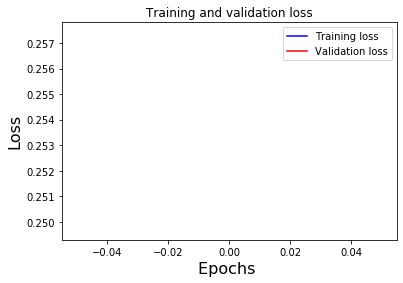

<Figure size 432x288 with 0 Axes>

Epoch: 2/20... Training loss: 0.2423 Validation loss: 0.2527
Epoch time: 4.13s


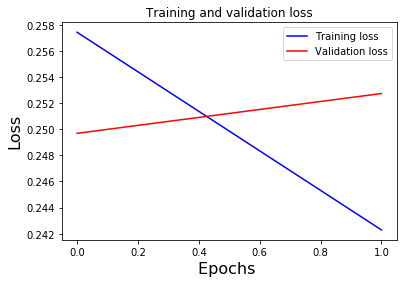

<Figure size 432x288 with 0 Axes>

Epoch: 3/20... Training loss: 0.2232 Validation loss: 0.2441
Epoch time: 4.12s


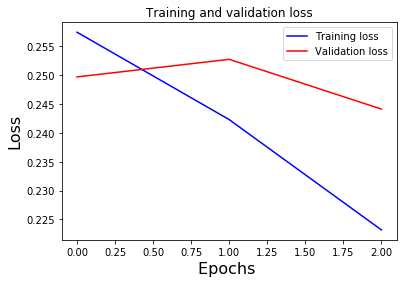

<Figure size 432x288 with 0 Axes>

Epoch: 4/20... Training loss: 0.2213 Validation loss: 0.2300
Epoch time: 4.15s


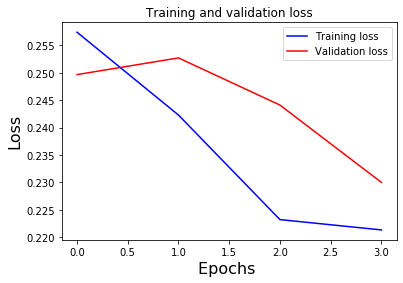

<Figure size 432x288 with 0 Axes>

Epoch: 5/20... Training loss: 0.1987 Validation loss: 0.2304
Epoch time: 4.14s


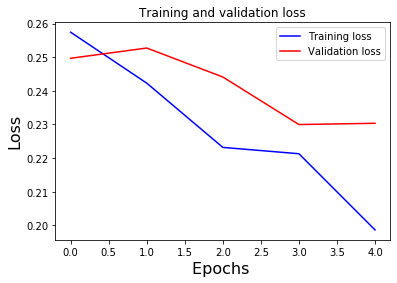

<Figure size 432x288 with 0 Axes>

Epoch: 6/20... Training loss: 0.2121 Validation loss: 0.2197
Epoch time: 4.18s


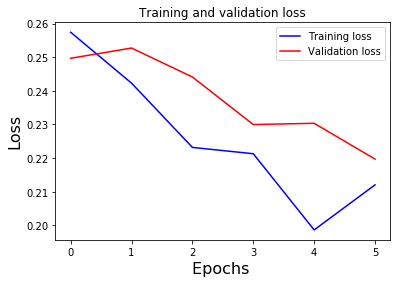

<Figure size 432x288 with 0 Axes>

Epoch: 7/20... Training loss: 0.2063 Validation loss: 0.2120
Epoch time: 4.16s


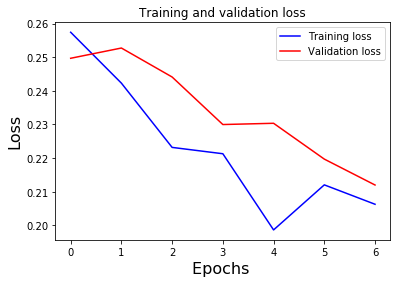

<Figure size 432x288 with 0 Axes>

Epoch: 8/20... Training loss: 0.1945 Validation loss: 0.2016
Epoch time: 4.21s


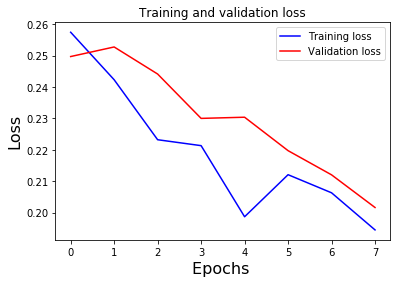

<Figure size 432x288 with 0 Axes>

Epoch: 9/20... Training loss: 0.1808 Validation loss: 0.2054
Epoch time: 4.34s


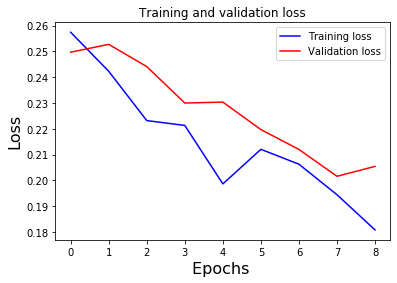

<Figure size 432x288 with 0 Axes>

Epoch: 10/20... Training loss: 0.1811 Validation loss: 0.2036
Epoch time: 4.28s


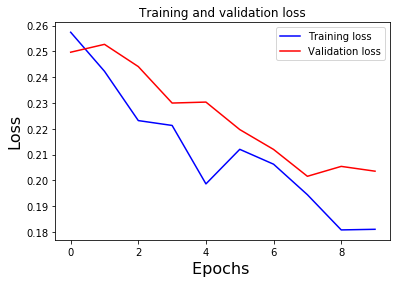

<Figure size 432x288 with 0 Axes>

Epoch: 11/20... Training loss: 0.1811 Validation loss: 0.2036
Epoch time: 4.26s


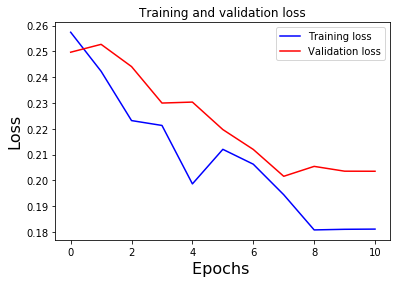

<Figure size 432x288 with 0 Axes>

Epoch: 12/20... Training loss: 0.1631 Validation loss: 0.1969
Epoch time: 4.40s


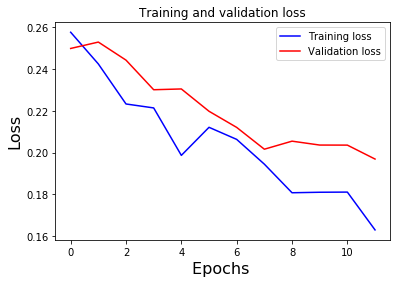

<Figure size 432x288 with 0 Axes>

Epoch: 13/20... Training loss: 0.1603 Validation loss: 0.1977
Epoch time: 4.26s


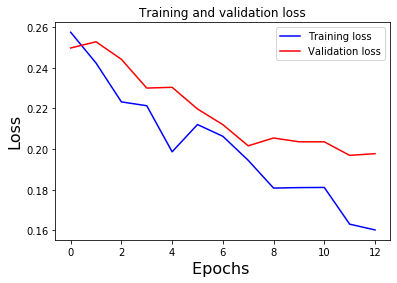

<Figure size 432x288 with 0 Axes>

Epoch: 14/20... Training loss: 0.1621 Validation loss: 0.1961
Epoch time: 4.27s


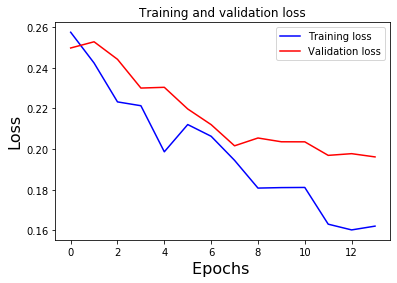

<Figure size 432x288 with 0 Axes>

Epoch: 15/20... Training loss: 0.1561 Validation loss: 0.1776
Epoch time: 4.31s


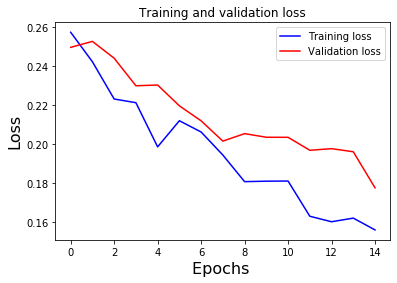

<Figure size 432x288 with 0 Axes>

Epoch: 16/20... Training loss: 0.1500 Validation loss: 0.1817
Epoch time: 4.33s


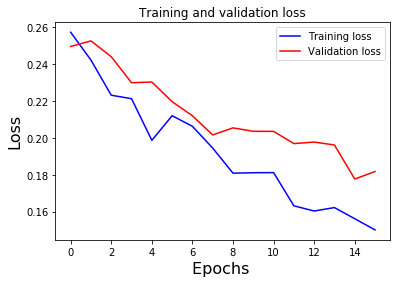

<Figure size 432x288 with 0 Axes>

Epoch: 17/20... Training loss: 0.1525 Validation loss: 0.1967
Epoch time: 4.35s


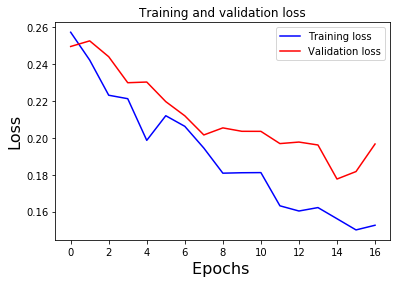

<Figure size 432x288 with 0 Axes>

Epoch: 18/20... Training loss: 0.1504 Validation loss: 0.2082
Epoch time: 4.53s


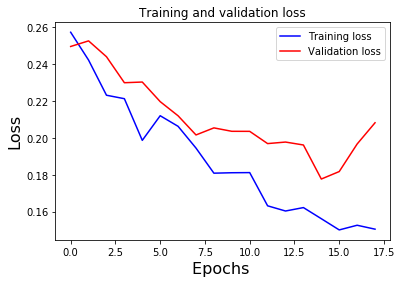

<Figure size 432x288 with 0 Axes>

Epoch: 19/20... Training loss: 0.1508 Validation loss: 0.1882
Epoch time: 4.41s


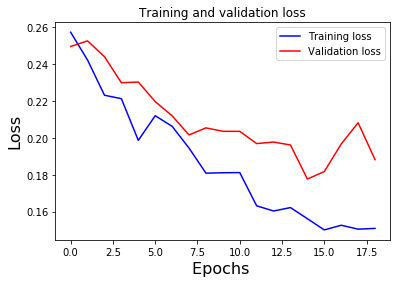

<Figure size 432x288 with 0 Axes>

Epoch: 20/20... Training loss: 0.1423 Validation loss: 0.1924
Epoch time: 4.38s


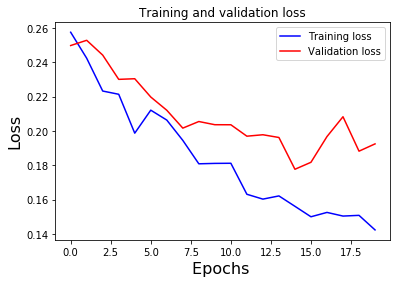

<Figure size 432x288 with 0 Axes>

In [15]:
import time

start = time.time()
epoch_time = []

for e in range(epochs):
    total_batch = int( N_input/ batch_size)
    for ibatch in range(total_batch):
        x_train_noisy , imgs_train  = next_batch(batch_size , train_imgs , train_origins)
        x_test_noisy , imgs_test =  next_batch(batch_size , test_imgs, test_origins)

        x_train_noisy = x_train_noisy.reshape((-1,28,28,1))
        imgs_train = imgs_train.reshape((-1,28,28,1)) 
        x_test_noisy = x_test_noisy.reshape((-1,28,28,1))
        imgs_test = imgs_test.reshape((-1,28,28,1))
            
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_:x_train_noisy ,targets_:imgs_train, learning_rate:lr})

        batch_cost_test = sess.run(cost, feed_dict={inputs_:x_test_noisy,targets_:imgs_test})
    if (e + 1) % display_step == 0:
        print("Epoch: {}/{}...".format(e + 1, epochs),
              "Training loss: {:.4f}".format(batch_cost),
              "Validation loss: {:.4f}".format(batch_cost_test))
        now = time.time()
        epoch_t = now - start
        epoch_time.append(epoch_t)
        start = now
        print('Epoch time: {:.2f}s'.format(epoch_t))

    loss.append(batch_cost)
    valid_loss.append(batch_cost_test)
    plt.plot(range(e + 1), loss, 'b', label='Training loss')
    plt.plot(range(e + 1), valid_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()
    saver.save(sess, './encode_model/')


利用训练得到的模型测试1-24hours的数据结果。

In [0]:
def get_test_data(N_start, N_end):

  Final_test = []
  Final_origin = []

  for i in range(N_start, N_end):
    if i % 2 == 1:
      Final_test.append(imgs_all[i])
      Final_origin.append(origins_all[i])

  Final_test = np.array(Final_test).astype(float)   
  Final_origin = np.array(Final_origin).astype(float)

  return Final_test/255.0, Final_origin/255.0

测试平均SSIM值。

In [31]:
Number = 1000

A_SSIM = []
C = []
for m in range(23):
  x, y = get_test_data(N[m],N[m+1])

  x_test_noisy , imgs_test = next_batch (Number , x, y)

  x_test_noisy = x_test_noisy.reshape((-1,28,28,1))
  imgs_test = imgs_test.reshape((-1,28,28,1))

  recon_img = sess.run([decoded], feed_dict={inputs_: x_test_noisy})[0]

  SSIM_test = []

  for i in range(Number):
    s = ssim(recon_img[i,...,0],imgs_test[i,...,0])
    SSIM_test.append(s)

  C.append(m)
  A_SSIM.append(sum(SSIM_test)/Number)
  print('The {} - {} hours:'.format(m,m+1))
  print('average SSIM = {:.2f}'.format(sum(SSIM_test)/Number))
  print('SSIM variance = {:.4f}'.format(np.var(SSIM_test)))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


The 0 - 1 hours:
average SSIM = 0.73
SSIM variance = 0.0117
The 1 - 2 hours:
average SSIM = 0.73
SSIM variance = 0.0112
The 2 - 3 hours:
average SSIM = 0.64
SSIM variance = 0.0200
The 3 - 4 hours:
average SSIM = 0.60
SSIM variance = 0.0201
The 4 - 5 hours:
average SSIM = 0.59
SSIM variance = 0.0184
The 5 - 6 hours:
average SSIM = 0.59
SSIM variance = 0.0189
The 6 - 7 hours:
average SSIM = 0.60
SSIM variance = 0.0195
The 7 - 8 hours:
average SSIM = 0.58
SSIM variance = 0.0202
The 8 - 9 hours:
average SSIM = 0.55
SSIM variance = 0.0217
The 9 - 10 hours:
average SSIM = 0.55
SSIM variance = 0.0205
The 10 - 11 hours:
average SSIM = 0.58
SSIM variance = 0.0203
The 11 - 12 hours:
average SSIM = 0.59
SSIM variance = 0.0189
The 12 - 13 hours:
average SSIM = 0.58
SSIM variance = 0.0236
The 13 - 14 hours:
average SSIM = 0.56
SSIM variance = 0.0208
The 14 - 15 hours:
average SSIM = 0.57
SSIM variance = 0.0235
The 15 - 16 hours:
average SSIM = 0.62
SSIM variance = 0.0194
The 16 - 17 hours:
average 

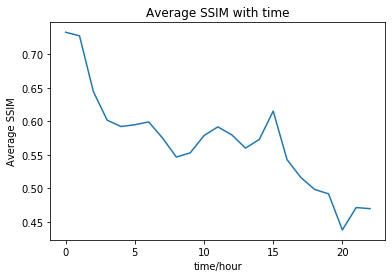

In [34]:
plt.figure()
plt.title('Average SSIM with time')
plt.xlabel('time/hour')
plt.ylabel('Average SSIM')
plt.plot(C,A_SSIM)
plt.show()

画出结果。

Reconstruction time for 10 images = 0.01s
Original Images


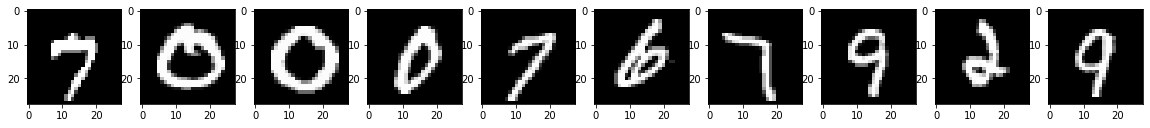

Multimode fiber images


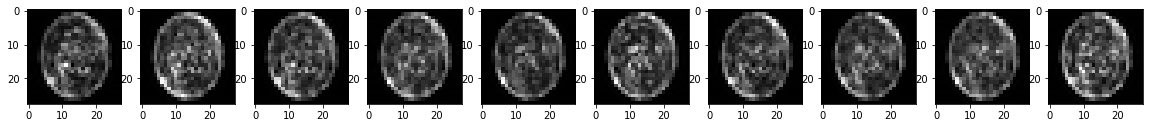

Reconstruction of Multimode fiber Images


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


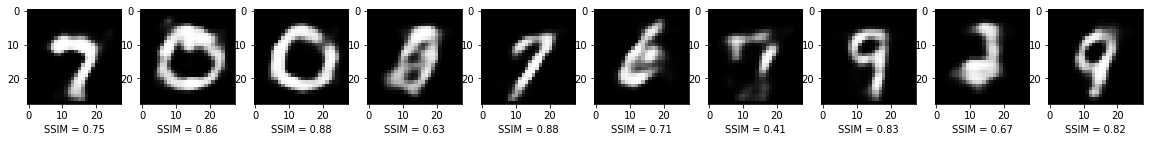

In [22]:
x_test_noisy , imgs_test = next_batch ( 10 , x, y)

x_test_noisy = x_test_noisy.reshape((-1,28,28,1))
imgs_test = imgs_test.reshape((-1,28,28,1))

recon_begin = time.time()
recon_img = sess.run([decoded], feed_dict={inputs_: x_test_noisy})[0]
recon_end = time.time()
print('Reconstruction time for 10 images = {:.2f}s'.format(recon_end - recon_begin))
plt.figure(figsize=(20, 4))
plt.title('Reconstructed Images')
print("Original Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(imgs_test[i,...,0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Multimode fiber images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test_noisy[i,...,0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Multimode fiber Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(recon_img[i,...,0], cmap='gray')
    s = ssim(recon_img[i,...,0],imgs_test[i,...,0])
    plt.xlabel('SSIM = {:.2f}'.format(s))
plt.show()


In [0]:
'''
writer.close()
sess.close()

'''

最后一步，留下一个测试记录吧！！！

In [0]:
import datetime
import pytz
tz_sg = pytz.timezone('Asia/Singapore')

def creat_records():
  R = {}

  #special information

  R['Special information'] = special_information

  # About time cost
  R['record_time'] = datetime.datetime.now(tz_sg)
  R['Average_epoch_time'] = round(sum(epoch_time)/len(epoch_time),2)
  R['Reconstruction time for 10 pics'] = round(recon_end - recon_begin,2)

  # About SSIM
  R['Average_SSIM'] = round(sum(SSIM_test)/Number,2)
  R['SSIM_variance'] = round(np.var(SSIM_test),4)

  # About neural network parameter
  R['filter_Number'] = filter_Number
  R['epochs'] = epochs
  R['batch_size'] = batch_size
  R['learning_rate'] = lr
  
  return R

try:
  with open('Test_records.dat', 'rb') as f:
    record = pickle.load(f)
  R = creat_records()
  record.append(R)
  with open('Test_records.dat', 'wb') as f:
    pickle.dump(record,f)
except:
  record = []
  R = creat_records()
  record.append(R)
  with open('Test_records.dat', 'wb') as f:
    pickle.dump(record,f)


读取测试记录。

In [0]:
with open('Test_records.dat', 'rb') as f:
    record = pickle.load(f)

print('共有{}次记录\n'.format(len(record)))

for i in range(len(record)):
  R = record[i]
  print('第{}次记录：\n'.format(i+1))
  for k in R:
    print('{}: {}\n'.format(k,R[k]))